# Caches and Data Locality

In [7]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray

make clean
make VERSION=orig
make VERSION=counters
make VERSION=kblocking
make VERSION=inlining
make VERSION=inlining_v2

rm -f -rf *~ *.o *.mod *.MOD *.i *.x *.x+orig *.x+[0-9]* core.* *.out
ftn -eZ -ffree -N255 -ec -eC -eI -eF -c m_utils.F90
ftn -eZ -ffree -N255 -ec -eC -eI -eF -c stencil2d-orig.F90
ftn -eZ -ffree -N255 -ec -eC -eI -eF m_utils.o stencil2d-orig.o -o stencil2d-orig.x
cp stencil2d-orig.x stencil2d.x
ftn -eZ -ffree -N255 -ec -eC -eI -eF -c stencil2d-counters.F90
ftn -eZ -ffree -N255 -ec -eC -eI -eF m_utils.o stencil2d-counters.o -o stencil2d-counters.x
cp stencil2d-counters.x stencil2d.x
ftn -eZ -ffree -N255 -ec -eC -eI -eF -c stencil2d-kblocking.F90
ftn -eZ -ffree -N255 -ec -eC -eI -eF m_utils.o stencil2d-kblocking.o -o stencil2d-kblocking.x
cp stencil2d-kblocking.x stencil2d.x
ftn -eZ -ffree -N255 -ec -eC -eI -eF -c stencil2d-inlining.F90
ftn -eZ -ffree -N255 -ec -eC -eI -eF m_utils.o stencil2d-inlining.o -o stencil2d-inlining.x
cp stencil2d-inlining.x stencil2d.x
ftn -eZ -ffree -N255 -ec -eC -eI -eF -c stencil2d-inlining_v2.F90
ftn -eZ -ffree -N255 -ec -eC -eI -eF m_utils.o stencil2d-inl

In [5]:
%%bash
for tag in orig kblocking inlining inlining_v2 ; do
    echo "=> running stencil2d-${tag}.x in scan mode (output in result_stencil2d-${tag}.py)"
    srun -n 12 ./stencil2d-${tag}.x --scan --nz 64 --num_iter 128 1> result_stencil2d-${tag}.py
done

=> running stencil2d-orig.x in scan mode (output in result_stencil2d-orig.py)
=> running stencil2d-kblocking.x in scan mode (output in result_stencil2d-kblocking.py)
=> running stencil2d-inlining.x in scan mode (output in result_stencil2d-inlining.py)
=> running stencil2d-inlining_v2.x in scan mode (output in result_stencil2d-inlining_v2.py)


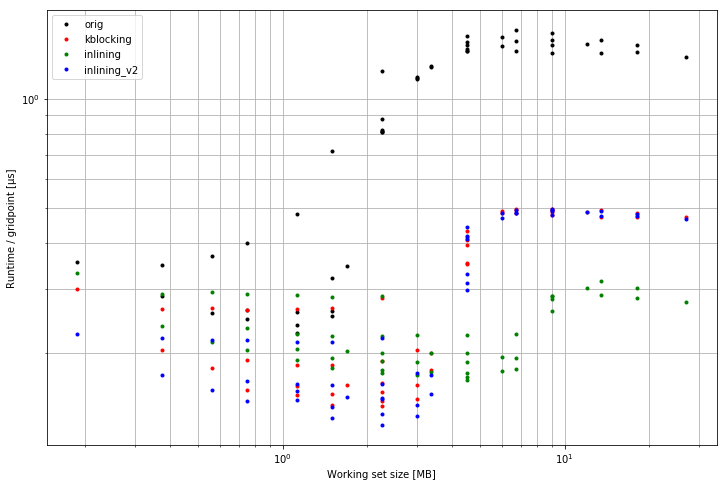

In [15]:
tags = [ "orig", "kblocking", "inlining", "inlining_v2" ]
colors = [ "black", "red", "green", "blue" ]
for tag, color in zip(tags, colors):
    exec(open("result_stencil2d-" + tag + ".py").read())
    vars()["data_" + tag] = data
    nxnynz = data[:, 1] * data[:, 2] * data[:, 3]
    runtime = data[:, 5]
    plt.loglog( 3 * nxnynz * 4 / 1024. / 1024., runtime / nxnynz * 1.0e6 , '.', color=color);
plt.xlabel( 'Working set size [MB]' );
plt.ylabel( 'Runtime / gridpoint [µs]' );
plt.grid(b=True, which='both')
plt.legend(tags)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 8)